In [1]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

# Импорт моделей
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

#  Убираем предупрждения
import warnings
warnings.simplefilter(action='error', category=FutureWarning)

https://archive.ics.uci.edu/ml/datasets/wine+quality


In [2]:
# Загрузка датасета
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(link, sep=';')

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data.shape

(1599, 12)

1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.


In [5]:
# Выделим признаки и целевую переменную
X, y = data.iloc[:,:-1], data.iloc[:,-1]

In [6]:
models =[
            RandomForestClassifier(n_estimators=100),
            BaggingClassifier(n_estimators=100),
            DecisionTreeClassifier()
        ]

In [7]:
for model in models:
    start_time = time.time()
    cvs = cross_val_score(model,X, y, scoring='accuracy', cv=5).mean()
    elapsed_time = time.time() - start_time
    print('Модель:', model)
    print('Время выполнения: %.3f' %elapsed_time)
    print('cross_val_score - ',cvs, '\n')
    print('----')

Модель: RandomForestClassifier()
Время выполнения: 1.064
cross_val_score -  0.5684855015673981 

----
Модель: BaggingClassifier(n_estimators=100)
Время выполнения: 2.530
cross_val_score -  0.5578448275862069 

----
Модель: DecisionTreeClassifier()
Время выполнения: 0.039
cross_val_score -  0.4752919278996865 

----


---
У моделей RandomForestClassifier и BaggingClassifier практически одинаковый результат, но первая выполняется в 2 раза быстрее.
DecisionTreeClassifier показал результат хуже, но показывает лучший результат по скорости.

2.Разделите выборку на обучающую и тестовую в отношении 70%/30%


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=242)

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:

10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.


In [9]:
N = [10, 50, 100] + [n for n in range(200,5001,200)]
scores = []

for n in N:
    clf = RandomForestClassifier(n_estimators=int(n), n_jobs=-1)
    clf.fit(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    scores.append({'n':int(n), 'score_test':score_test})

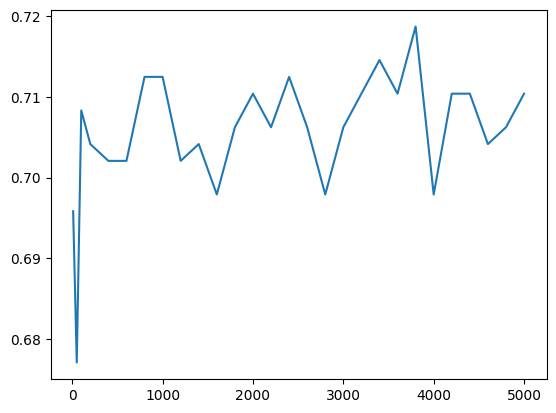

In [10]:
scores_df = pd.DataFrame(scores)

plt.plot(scores_df.n, scores_df.score_test)

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score


In [11]:
boostings = [
                XGBClassifier(),
                GradientBoostingClassifier()
            ]

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
for boosting in boostings:
    start_time = time.time()
    cvs = cross_val_score(boosting, X, y, scoring='accuracy', cv=5).mean()
    elapsed_time = time.time() - start_time
    print('Модель:', boosting)
    print('Время выполнения: %.3f' %elapsed_time)
    print('cross_val_score - ', cvs, '\n')
    print('----')

Модель: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
Время выполнения: 2.489
cross_val_score -  0.5472335423197492 

----
Модель: GradientBoostingClassifier()
Время выполнения: 5.675
cross_val_score -  0.5647257053291537 

----


5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.


In [14]:
# Задаем параметры для GridSearchCV
params = {
            'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'n_estimators' : [1, 2, 4, 8, 16, 32],
            'max_depth' : range(1,10,1)
            }

In [15]:
search =GridSearchCV(XGBClassifier(), param_grid=params, scoring='accuracy', cv=5, n_jobs=-1).fit(X, y)
print('Модель:', XGBClassifier())
print('Лучшие параметры',search.best_params_)
print(search.best_score_)

Модель: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
Лучшие параметры {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 4}
0.5947452978056426


In [16]:
search =GridSearchCV(GradientBoostingClassifier(), param_grid=params, scoring='accuracy', cv=5, n_jobs=-1).fit(X, y)
print('Модель:', GradientBoostingClassifier())
print('Лучшие параметры',search.best_params_)
print(search.best_score_)

Модель: GradientBoostingClassifier()
Лучшие параметры {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 32}
0.586632053291536


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.


In [17]:
start_time = time.time()
cvs = cross_val_score(LGBMClassifier(), X, y, scoring="accuracy", cv=5).mean()
elapsed_time = time.time() - start_time
print('Модель:',LGBMClassifier.__name__, '\n')
print('Время выполнения: %.3f' %elapsed_time)
print('cross_val_score - ', cvs, '\n')

Модель: LGBMClassifier 

Время выполнения: 2.334
cross_val_score -  0.5572472570532915 



In [18]:
start_time = time.time()
cvs = cross_val_score(CatBoostClassifier(), X, y).mean()
elapsed_time = time.time() - start_time
print('Модель:',CatBoostClassifier.__name__, '\n')
print('Время выполнения: %.3f' %elapsed_time)
print('cross_val_score - ', cvs, '\n')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/catboost/core.py", line 2339, in _fit
    train_params = self._prepare_train_params(
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/catboost/core.py", line 2220, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/catboost/core.py", line 1438, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/catboost/core.py", line 792, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/catboost/core.py", line 1419, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3953, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4003, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3819, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2729, in _catboost._set_features_order_data_pd_data_frame
  File "/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/pandas/core/frame.py", line 1357, in iteritems
    warnings.warn(
FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


---
CatBoostClassifier. Не смог получить значение cross_val_score. Решение ошибки не нашел.

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.


In [19]:
search =GridSearchCV(LGBMClassifier(), param_grid=params, scoring='accuracy', cv=5, n_jobs=-1).fit(X, y)
print('Модель:', LGBMClassifier())
print('Лучшие параметры',search.best_params_)
print(search.best_score_)

Модель: LGBMClassifier()
Лучшие параметры {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 16}
0.5910031347962382


In [22]:
models = [
    LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators= 16),
    GradientBoostingClassifier(learning_rate= 0.05, max_depth= 2, n_estimators= 32),
    XGBClassifier(learning_rate= 0.5, max_depth= 5, n_estimators= 4)
]

for model in models:
    start_time = time.time()
    cvs = cross_val_score(model, X,y, scoring='accuracy', cv=5, n_jobs=-1).mean()
    elapsed_time = time.time() - start_time
    print('Модель:', model)
    print('Время выполнения: %.3f' %elapsed_time)
    print('cross_val_score - ', cvs, '\n')

Модель: LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=16)
Время выполнения: 0.130
cross_val_score -  0.5910031347962382 

Модель: GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=32)
Время выполнения: 0.528
cross_val_score -  0.587259012539185 

Модель: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=4, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=

XGBClassifier показал лучший результат по accuracy и скорости.

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [hyperopt](https://github.com/hyperopt/hyperopt) . Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.


9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.


In [26]:
estimators = [
    ('lgbmc', LGBMClassifier()),
    ('rfc', GradientBoostingClassifier()),
    ('xgbc', XGBClassifier())
]
stacked = StackingClassifier(estimators=estimators)
start_time = time.time()
cvs = cross_val_score(estimator=stacked, X=X, y=y, scoring='accuracy', cv=5, n_jobs=-1).mean()
elapsed_time = time.time() - start_time
print('Время выполнения: %.3f' %elapsed_time)
print('cross_val_score - ', cvs, '\n')

Время выполнения: 12.449
cross_val_score -  0.5841183385579937 



/Users/matdiv/opt/anaconda3/envs/boost/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.


In [25]:
estimators = [
    ('lgbmc', LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators= 16)),
    ('rfc', GradientBoostingClassifier(learning_rate= 0.05, max_depth= 2, n_estimators= 32)),
    ('xgbc', XGBClassifier(learning_rate= 0.5, max_depth= 5, n_estimators= 4))
]
stacked = StackingClassifier(estimators=estimators)
start_time = time.time()
cvs = cross_val_score(estimator=stacked, X=X, y=y, scoring='accuracy', cv=5, n_jobs=-1).mean()
elapsed_time = time.time() - start_time
print('Время выполнения: %.3f' %elapsed_time)
print('cross_val_score - ', cvs, '\n')

Время выполнения: 2.247
cross_val_score -  0.5885148902821318 



---
Стэкинг оптимальных моделей показал результат лучше, чем модели с базовыми настройками, но не намного. Стэкинг оптимальных моделей выполнятся в 6 раз быстрей.